### Install needed packages

In [ ]:
!pip install SoccerNet --upgrade
!pip install transformers
!pip install ffmpeg
!pip install torch
!pip install ffmpeg-python
!pip install accelerate
!pip install tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=957e0dedebe6749c7c88c886b6e8a5ce8b465ff4452cdf4cae8e8a34c1513887
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Us

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Download our dataset from SoccerNet

In [ ]:
from SoccerNet.Downloader import SoccerNetDownloader

password = "s0cc3rn3t"

def unlabeled_dataset(LocalDirectory):
    myDownloader = SoccerNetDownloader(LocalDirectory=LocalDirectory)
    myDownloader.password = password
    myDownloader.downloadGames(files=["1_224p.mkv", "2_224p.mkv"], split=["train","valid","test","challenge"])

def labeled_dataset(LocalDirectory):
    myDownloader = SoccerNetDownloader(LocalDirectory=LocalDirectory)
    myDownloader.password = password
    myDownloader.downloadGames(files=["Labels-v2.json"], split=["train","valid","test"])

#unlabeled_dataset("drive/MyDrive/DTX/Football-Dataset/")
#labeled_dataset("drive/MyDrive/DTX/Football-Dataset/")

### Import our dependencies

In [2]:
#import ffmpeg
import tensorflow as tf
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline, BertTokenizer, BertModel
import torch
import os
import shutil
import time
import pandas as pd
import numpy as np
import json

### Build our model

In [ ]:

def build_model(model_id):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
    print("Running model on:", device)

    model = AutoModelForSpeechSeq2Seq.from_pretrained(
        model_id,
        torch_dtype=torch_dtype,
        use_safetensors=True
    )
    model.to(device)

    processor = AutoProcessor.from_pretrained(model_id, language="en")

    pipe = pipeline(
        "automatic-speech-recognition",
        model=model,
        tokenizer=processor.tokenizer,
        feature_extractor=processor.feature_extractor,
        max_new_tokens=128,
        chunk_length_s=30,
        batch_size=16,
        return_timestamps=True,
        torch_dtype=torch_dtype,
        device=device,
    )

    return pipe

model_id = "openai/whisper-large"
model_ids = ["openai/whisper-base", "openai/whisper-small", "openai/whisper-medium", "openai/whisper-large", "openai/whisper-large-v2", "openai/whisper-large-v3"]
pipe = build_model(model_id=model_id)

Running model on: cuda:0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

KeyboardInterrupt: 

### Fragment audio and translate audio to text

In [ ]:
# environment variables
#local_dir = "drive/MyDrive/DTX/Football-Dataset"
dir = "drive/MyDrive/DTX/england_epl/"

def update_txt_file(text, path):
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)


def audio_to_text(pipe, model_id):
  for year in os.listdir(dir):
      games = os.path.join(dir, year)
      for game in os.listdir(games):
          print(f'\nGame: {game}')
          if game != ".ipynb_checkpoints":
              game_dir = os.path.join(games, game)
              frag1_dir = os.path.join(game_dir, "fragments_1_224p")
              frag2_dir = os.path.join(game_dir, "fragments_2_224p")

              for audioFrag1 in os.listdir(frag1_dir):
                result = pipe(frag1_dir + '/' + audioFrag1, return_timestamps=True,  generate_kwargs = {"language": "english", "task": "translate"})
                update_txt_file(result['text'], frag1_dir + f'/{audioFrag1[:-4]}__{model_id[7:]}.txt')
                print(f'\nHalf 1, Fragment {audioFrag1}')
              for audioFrag2 in os.listdir(frag2_dir):
                result = pipe(frag2_dir + '/' + audioFrag2, return_timestamps=True,  generate_kwargs = {"language": "english", "task": "translate"})
                update_txt_file(result['text'], frag2_dir + f'/{audioFrag2[:-4]}__{model_id[7:]}.txt')
                print(f'\nHalf 1, Fragment {audioFrag2}')


def clear_nonvideos(path):
    for t in os.listdir(path):
        if os.path.isdir(path + '/' + t):
          shutil.rmtree(path + '/' + t)
        else:
          if not t.endswith(".mkv"):
             os.remove(path + '/' + t)


def fragment_dataset_audio(audio_cut_length, offset):
  for year in os.listdir(dir):
      games = os.path.join(dir, year)
      for game in os.listdir(games):
          game_dir = os.path.join(games, game)

          if game != ".ipynb_checkpoints":
            clear_nonvideos(game_dir)
            for videoFile in os.listdir(game_dir):
                pathVideo = game_dir + "/" + videoFile
                videoFragments = game_dir + f"/fragments_{videoFile[:-4]}"

                # este if não está a funcionar como é suposto
                if not os.path.exists(videoFragments):
                  print("Criei pasta: ", videoFragments)
                  os.mkdir(videoFragments)

                duration = float(ffmpeg.probe(pathVideo)["format"]["duration"])
                steps = duration/audio_cut_length
                for n in range(int(steps)+1):
                  try:
                    ffmpeg.input(pathVideo, ss=(n*audio_cut_length)-offset, to=(n+1)*audio_cut_length).output(videoFragments + f"/fragment_{n}.wav",ar=16000).run(quiet=True, overwrite_output=True)
                  except ffmpeg.Error as e:
                    print("Output: ", e.stdout)
                    print("Error: ", e.stderr)

#fragment_dataset_audio(audio_cut_length=30, offset=2)
#audio_to_text(pipe=pipe, model_id=model_id)

### Benchmarking of the fragmentation and audio translation

In [ ]:
def get_fragment_zero(m):
   with open(dir+f"2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/fragments_1_224p/fragment_0__{m[7:]}.txt", "r", encoding="utf-8") as f:
      return f.readline()


def sec_to_minsec(sec):

  min = int(sec / 60)
  sec2 = int((sec/60 - min) * 60)
  if sec2 < 10:
     sec2 = f"0{sec2}"
  else:
     sec2 = str(sec2)
  return f"{min}:"+sec2


def benchmark(flag):
    '''
    just 1 game in the dataset
    '''
    benchmarks_times = {}
    benchmarks_frags = {}

    for m in model_ids:
        fragment_dataset_audio(audio_cut_length=30, offset=2)
        start_time = time.time()
        pipe = build_model(model_id=m)
        audio_to_text(pipe, m)
        benchmarks_times[m] = sec_to_minsec(time.time() - start_time)
        frag0 = get_fragment_zero(m)
        benchmarks_frags[m] = frag0

    json1 = []

    for model in benchmarks_times:
        dados={"jogo": "2015-02-21 - 18-00 Chelsea 1 - 1 Burnley", "model": model, "run_time_per_game": benchmarks_times[model], "transcricao": benchmarks_frags[model]}
        json1.append(dados)

    with open(f"benchmark_{flag}.json", "w") as f:
        json.dump(json1,f,indent=2)

#nao correr
#benchmark("GPU")

## Build our own dataset

In [ ]:
def build_binary_labeled_dataset():
    base_path = "drive/MyDrive/DTX/Football-Dataset/england_epl/"
    id = 1

    f = open("binary_labeled_dataframe.csv", "w")
    f.write("id;league;game;fragment_start_time;fragment_end_time;commentary;model_id;label;\n")
    f.close()

    for year in os.listdir(base_path):
        games = os.path.join(base_path, year)
        for game in os.listdir(games):
            if game != '.ipynb_checkpoints':
                fragments_1 = os.path.join(games, game, "fragments_1_224p")
                fragments_2 = os.path.join(games, game, "fragments_2_224p")

                id = write_binary_labeled_fragments(folder=fragments_1, year=year, league="england_epl", game=game, half=1, id=id)
                id = write_binary_labeled_fragments(folder=fragments_2, year=year, league="england_epl", game=game, half=2, id=id)

    print("id: ", id)

"""
folder - path to the folder that has the fragments
league - league folder in which the game is inserted
year   - year in whice the game is inserted
game   - name of the correspondent game
half   - 1 if it is 1st half, 2 if it is 2nd half
audio_cut_length - size of the fragments
offset - size of the offset we are using to catch some audio from the last fragment.
"""
def write_binary_labeled_fragments(folder, league, year, game, half, id, audio_cut_length=30, offset=2):
    model_id = "openai/whisper-large"
    num_transcriptions = len(os.listdir(folder))//2

    # ex: (fragment_20.txt, 20)  -> (fragment file name, fragment_number)
    model_id = model_id[7:]
    fragment_file_names = [("fragment_" + str(i) + f"__{model_id}.txt", i) for i in range(num_transcriptions)]

    labels = os.path.join("drive/MyDrive/DTX/Football-Dataset/", league, year, game, "Labels-v2.json")

    l = open(labels, "r", encoding='utf-8')
    data = json.load(l)

    with open("drive/MyDrive/DTX/binary_labeled_dataframe.csv", 'a') as df:

        for fragment_file in fragment_file_names:
            possible_labels = set()
            fragment_path = os.path.join(folder, fragment_file[0])
            # These values are counted in seconds
            start_time = fragment_file[1] * audio_cut_length - offset
            end_time = (fragment_file[1]+1) * audio_cut_length

            f = open(fragment_path, "r")
            commentary = f.read()
            f.close()

            for annotation in data['annotations']:
                annotation_half = int(annotation['gameTime'][0])
                if annotation_half == half:
                    annotation_min =  int(annotation['gameTime'][-5:-3])
                    annotation_sec = int(annotation['gameTime'][-2:])

                    annotation_min_to_sec = annotation_min*60 + annotation_sec
                    if start_time < annotation_min_to_sec and end_time > annotation_min_to_sec:
                        possible_labels.add(annotation['label'])



            if possible_labels.intersection({"Shots on target", "Goal", "Penalty", "Red Card", "Yellow-red card"}):
                label = "Highlight"
            else:
                label = "Non-Highlight"

            row = str(id) + ";" + league + ";" + game + ";" + str(start_time) + ";" + str(end_time) + ";" + commentary + ";" + model_id + ";" + label + "\n"
            df.write(row)
            id+=1

    return id

build_binary_labeled_dataset()

id:  2068


In [ ]:
def build_multi_labeled_dataset():
    base_path = "drive/MyDrive/DTX/Football-Dataset/england_epl/"
    id = 1

    f = open("multi_labeled_dataframe.csv", "w")
    f.write("id;league;game;fragment_start_time;fragment_end_time;commentary;model_id;possible_labels;\n")
    f.close()

    for year in os.listdir(base_path):
        games = os.path.join(base_path, year)
        for game in os.listdir(games):
            if game != '.ipynb_checkpoints':
                fragments_1 = os.path.join(games, game, "fragments_1_224p")
                fragments_2 = os.path.join(games, game, "fragments_2_224p")

                id = write_multi_labeled_fragments(folder=fragments_1, year=year, league="england_epl", game=game, half=1, id=id)
                id = write_multi_labeled_fragments(folder=fragments_2, year=year, league="england_epl", game=game, half=2, id=id)

    print("id: ", id)

"""
folder - path to the folder that has the fragments
league - league folder in which the game is inserted
year   - year in whice the game is inserted
game   - name of the correspondent game
half   - 1 if it is 1st half, 2 if it is 2nd half
audio_cut_length - size of the fragments
offset - size of the offset we are using to catch some audio from the last fragment.
"""
def write_multi_labeled_fragments(folder, league, year, game, half, id, audio_cut_length=30, offset=2):
    model_id = "openai/whisper-large"
    num_transcriptions = len(os.listdir(folder))//2

    # ex: (fragment_20.txt, 20)  -> (fragment file name, fragment_number)
    model_id = model_id[7:]
    fragment_file_names = [("fragment_" + str(i) + f"__{model_id}.txt", i) for i in range(num_transcriptions)]

    labels = os.path.join("drive/MyDrive/DTX/Football-Dataset/", league, year, game, "Labels-v2.json")

    l = open(labels, "r", encoding='utf-8')
    data = json.load(l)

    with open("drive/MyDrive/DTX/multi_labeled_dataframe.csv", 'a') as df:

        for fragment_file in fragment_file_names:
            possible_labels = ""
            fragment_path = os.path.join(folder, fragment_file[0])
            # These values are counted in seconds
            start_time = fragment_file[1] * audio_cut_length - offset
            end_time = (fragment_file[1]+1) * audio_cut_length

            f = open(fragment_path, "r")
            commentary = f.read()
            f.close()

            for annotation in data['annotations']:
                annotation_half = int(annotation['gameTime'][0])
                if annotation_half == half:
                    annotation_min =  int(annotation['gameTime'][-5:-3])
                    annotation_sec = int(annotation['gameTime'][-2:])

                    annotation_min_to_sec = annotation_min*60 + annotation_sec
                    if start_time < annotation_min_to_sec and end_time > annotation_min_to_sec:
                        possible_labels += (annotation['label'] + '/')

            if possible_labels != "":
              row = str(id) + ";" + league + ";" + game + ";" + str(start_time) + ";" + str(end_time) + ";" + commentary + ";" + model_id + ";" + possible_labels[:-1] + "\n"
              df.write(row)
              id+=1

    return id

build_multi_labeled_dataset()

id:  1466


### Evaluate the model - Zero-Shot Classification


In [ ]:
!pip install pandas
!pip install scikit-learn

In [ ]:
#Dar load a base de dados
from sklearn import metrics
import matplotlib.pyplot as plt

#localPath = 'binary_labeled_dataframe.csv' #'./drive/MyDrive/DTX/Football-Dataset/binary_labeled_dataframe.csv'
#localPath = 'drive/MyDrive/binary_labeled_dataframe.csv' #'./drive/MyDrive/DTX/Football-Dataset/multi_labeled_dataframe.csv'
localPath = 'dataframes/multi_labeled_dataframe.csv' #'./drive/MyDrive/DTX/Football-Dataset/multi_labeled_dataframe.csv'

df = pd.read_csv(localPath, encoding='utf-8', sep=';')

classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
)

#candidate_labels = ["Shots on target, Goal, Penalty, Red card", "Ball out of play, Throw-in, Foul, Indirect free-kick, Clearance, Shots off target, Corner, Substitution, Kick-off, Direct free-kick, Offside, Yellow card"]
candidate_labels = ["Highlight", "Non-Highlight"]
#candidate_labels = ["Ball out of play", "Clearance", "Corner", "Shots on target", "Goal", "Red card"]


#--------------------DUAS LABELS labels highlight / labels non-highlight --------------
'''
predicts = []
true_labels = []

d = {"Shots on target, Goal, Penalty, Red card": 'Highlight',
    "Ball out of play, Throw-in, Foul, Indirect free-kick, Clearance, Shots off target, Corner, Substitution, Kick-off, Direct free-kick, Offside, Yellow card": 'Non-Highlight'
    }

for indice, linha in df.iterrows():
    sequence_to_classify = linha['commentary']
    res = classifier(sequence_to_classify, candidate_labels)
    predict = d[res['labels'][0]]
    predicts.append(predict)
    true_label = linha['label']
    true_labels.append(true_label)
    print(f"Linha: {indice}  Predicted a {predict} and it is a {true_label}")
'''




#--------------------DUAS LABELS Highlight / Non-Highlight --------------
'''
predicts = []

for indice, linha in df.iterrows():
    print(f'Linha: {indice}')
    sequence_to_classify = linha['commentary']
    res = classifier(sequence_to_classify, candidate_labels)
    predicts.append(res['labels'][0])


true_labels = list(df['label'])

'''

#-------------------LABELS TODAS-------------


'''
def labels_filter(linha):
    return (len(set(linha['possible_labels'].split('/')).intersection(set(candidate_labels))) > 0)

df_filtered= df[df.apply(labels_filter, axis=1)]

print(df_filtered)

predicts = []
true_labels = []
for indice, linha in df_filtered.iterrows():
    sequence_to_classify = linha['commentary']
    res = classifier(sequence_to_classify, candidate_labels)
    predict = res['labels'][0]
    predicts.append(predict)
    if res['labels'][0] in list(linha['possible_labels'].split("/")):
      true_label = predict
    else:
      true_label = list(  set(linha['possible_labels'].split("/")).intersection(set(candidate_labels))     )[0]   
    true_labels.append(true_label)
    print(f'id {indice+1}: Predicted {predict} and it is {true_label}')

'''


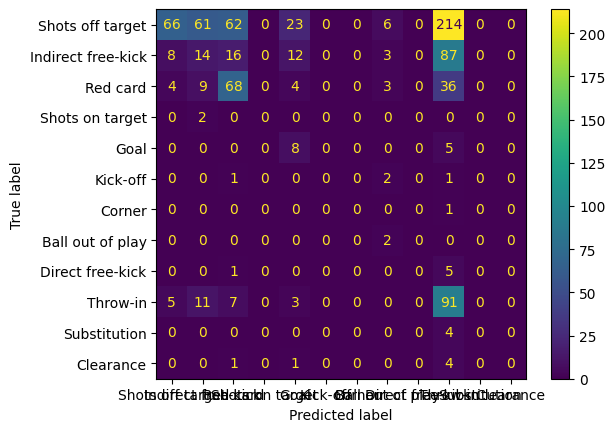

Matriz de Confusão:
[[ 66  61  62   0  23   0   0   6   0 214   0   0]
 [  8  14  16   0  12   0   0   3   0  87   0   0]
 [  4   9  68   0   4   0   0   3   0  36   0   0]
 [  0   2   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   8   0   0   0   0   5   0   0]
 [  0   0   1   0   0   0   0   2   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   2   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   5   0   0]
 [  5  11   7   0   3   0   0   0   0  91   0   0]
 [  0   0   0   0   0   0   0   0   0   4   0   0]
 [  0   0   1   0   1   0   0   0   0   4   0   0]]

Accuracy: 53.69%

Precision: 89.19%

Recall: 51.97%

F1-Score: 65.67%


In [ ]:
# Construir a matriz de confusão

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = metrics.confusion_matrix(true_labels, predicts)



# Exibir métricas 
#-------------------------------------- MULTI LABEL -------------------------------------------
'''
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=np.unique(predicts), yticklabels=np.unique(true_labels))
plt.xlabel('Labels Preditas')
plt.ylabel('Labels Reais')
plt.title('Matriz de Confusão')
plt.show()


tp = np.trace(confusion_matrix[3:6, 3:6]) #confusion_matrix[3, 3] + confusion_matrix[4, 4] + confusion_matrix[5, 5]
tn = np.trace(confusion_matrix[0:3, 0:3]) #confusion_matrix[0, 0] + confusion_matrix[1, 1] + confusion_matrix[2, 2]
fn = np.sum(confusion_matrix[0:6, 0:3]) - tn
fp = np.sum(confusion_matrix[0:6, 3:6]) - tp
'''
#-----------------------------------------------------------------------------------------------



#-------------------------------------- DUAS LABELS --------------------------------------------
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=candidate_labels)
cm_display.plot()
plt.show()


tp = confusion_matrix[0, 0]
fn = confusion_matrix[0, 1]
fp = confusion_matrix[1, 0]
tn = confusion_matrix[1, 1]
#-----------------------------------------------------------------------------------------------



percentagem_acerto = ((tp + tn) / (tp + fn + fp + tn)) * 100
precision=(tp/(tp+fp))*100
recall=(tp/(tp+fn))*100
f1_score = (tp/(tp + 0.5*(fp + fn)))*100


# Exibir a matriz de confusão e a percentagem de acerto
print("Matriz de Confusão:")
print(confusion_matrix)
print("\nAccuracy: {:.2f}%".format(percentagem_acerto))
print("\nPrecision: {:.2f}%".format(precision))
print("\nRecall: {:.2f}%".format(recall))
print("\nF1-Score: {:.2f}%".format(f1_score))


# Outro modelo do zeroshot classification

In [ ]:
classifier = pipeline("zero-shot-classification",model="sileod/deberta-v3-base-tasksource-nli")
candidate_labels = ["Highlight", "Non-Highlight"] #["Shots on target", "Goal", "Foul", "Corner"]

for indice, linha in df.iterrows():
  sequence_to_classify = linha[' commentary']

  res = classifier(sequence_to_classify, candidate_labels)

  df.at[indice, 'categoria2'] = res['labels'][0]

  df.at[indice, 'confianca2'] = res['scores'][0]

  print("Comentário: ", sequence_to_classify)
  print("Categoria: ", res['labels'][0], "Classificação: ", res['scores'][0], "\n\n")

config.json:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Comentário:   Mark Mitch For the continued work the dry Sun A half minute in and Continue produces work from the top draw to put Liverpool ahead Wow, what a fantastic strike that is Stunning goal Absolutely stunning goal just looking at his technique the goal. I'm just looking at his technique. I mean, it's a umbrella to be slow build up from New York for nobody in the ground for a minute was going to hit him. And there he bends it with power.
Categoria:  Goal Classificação:  0.8347603678703308 


Comentário:   the last 16 games in all competitions, but Southampton proved at the other end straightaway. And Annie as effort is blocked, he flipped it away for a corner. The Southampton players and fans think they should have had another penalty there. Wow, there's all happened, he's slipped on. Wow, I feel there, he hasn't made any contact with the ball there, he can do. Yeah, that's for me, that's a penalty. the
Categoria:  Corner Classificação:  0.6551027894020081 


Comentário:   the re

# Instalar Packages para o fewshotclassification

In [ ]:
!pip install stormtrooper[setfit]
!pip install stormtrooper[torch]

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.3 MB/s eta 0:00:00
  Created wheel for thefuzz: filename=thefuzz-0.18.0-py2.py3-none-any.whl size=18200 sha256=7545f1108e1cf08c7e9d2f1215822f0b2bdcb9912397cd5f0156145273302a06
  Stored in directory: /root/.cache/pip/wheels/8f/5b/ba/9b1a261ddd5216f10d8c6b14007d5db4b1aa16a4556d682031
Successfully built thefuzz
  Attempting u

In [ ]:
from stormtrooper import GenerativeFewShotClassifier, SetFitFewShotClassifier
import pandas as pd

#colabPath = '/content/drive/MyDrive/DTX/dataframe1.csv'
localPath = 'binary_labeled_dataframe.csv'
dados = pd.read_csv(localPath, encoding='utf-8' , sep=';', header = 0)

print(dados["commentary"])

0        The first one starts the game. The ball that ...
1        for the Euro 2016 qualifiers and we saw it he...
2        energy and intensity that the team has, but a...
3        A bit selfish, he apologizes there. He's a ve...
4        When the ball is in his court, Alex McCarthy ...
                              ...                        
2062     Drogba, the center of Drogba, Diego Costa, to...
2063     He's not attacking that ball well because obv...
2064     all the intensity that you have to put in unt...
2065     He may have felt mistreated from an arbitral ...
2066                       and I thank the team for that.
Name: commentary, Length: 2067, dtype: object


# Fewshot classification

In [ ]:


#amostras = [
#   " Mark Mitch For the continued work the dry Sun A half minute in and Continue produces work from the top draw to put Liverpool ahead Wow, what a fantastic strike that is Stunning goal Absolutely stunning goal just looking at his technique the goal. I'm just looking at his technique. I mean, it's a umbrella to be slow build up from New York for nobody in the ground for a minute was going to hit him. And there he bends it with power.",
#    " the last 16 games in all competitions, but Southampton proved at the other end straightaway. And Annie as effort is blocked, he flipped it away for a corner. The Southampton players and fans think they should have had another penalty there. Wow, there's all happened, he's slipped on. Wow, I feel there, he hasn't made any contact with the ball there, he can do. Yeah, that's for me, that's a penalty. the",
#    ' the referee has got that wrong. Same per involved. The Joe Zayfon does the Southampton captain. Leeds the delegation of protestees to referee Kevin Train. Joe Allen was the Liverpool player involved. The player make any contact with the board. Jerry Chitchis calls real problems in the opening five minutes of his game that Southampton finds themselves behind the table. The player is going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be in the middle of the ball. The two of them are going to be',
#    " the ball works in by targets from the former and in the end, Minu 8, 10. We've got another corner. And Liverpool can just calm things down. But exactly that's what they need to do. I'm guaranteed to involve again. He's making that run right through the middle of that little receiver. So it's for not a care in these open exchanges from one end to the other. Fascinating. For NETIC here in these open exchanges from one end to the other, fascinating."
#]

#candidate_labels = ['Goal', 'Shots on target', 'Corner', 'Foul']
training_data = pd.concat([group.sample(132) if label == 'Highlight' else group.sample(200)
                           for label, group in dados.groupby('label')])

test_data = dados.drop(index=training_data.index)
test_data = pd.concat([group.sample(20) if label == 'Highlight' else group.sample(1715)
                           for label, group in test_data.groupby('label')])


#comments = dados['commentary'].tolist()
#labels = dados['label'].tolist()

#few_shot_examples = comments[:20]
#few_shot_labels = labels[:20]

# Fit the model with few-shot examples and labels
model = SetFitFewShotClassifier("sentence-transformers/all-MiniLM-L6-v2").fit(training_data["commentary"], training_data["label"])

# Predict the labels for all comments
predictions = model.predict(test_data["commentary"])

# Add the predicted labels to the dataset
#dados['predicted_label'] = predictions

# Definir display.max_rows como None para exibir todas as linhas
#pd.set_option('display.max_rows', None)

#print(dados[['label', 'predicted_label']])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 13280
  Num epochs = 1
  Total optimization steps = 830
  Total train batch size = 16


Step,Training Loss
500,0.204600


# Matriz Confusao do modelo Fewshot classification

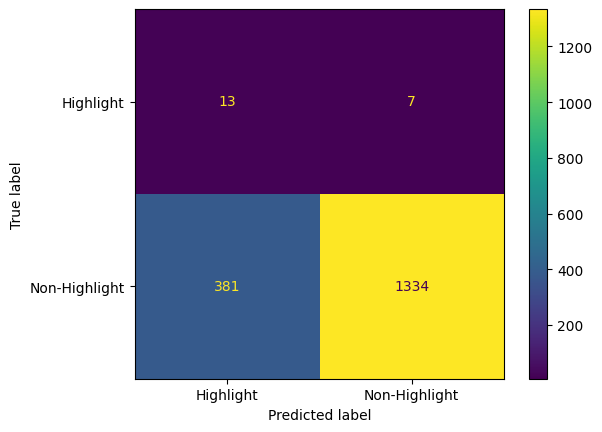

77.63688760806916


In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt


# Construir a matriz de confusão
confusion_matrix = metrics.confusion_matrix(test_data['label'], predictions)
candidate_labels = ["Highlight", "Non-Highlight"] #['Goal', 'Foul', 'Corner', 'Shots on target']

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=candidate_labels)
cm_display.plot()
plt.show()

# Calcular as percentagens de acerto
total_predicoes = np.sum(confusion_matrix)
predicoes_corretas = np.trace(confusion_matrix)
percentagem_acerto = predicoes_corretas / total_predicoes * 100\

print(percentagem_acerto)


In [ ]:
model.predict(['Ivanovic, foul! I think yellow card maybe. No, its red. Hes walking to the bench. Ivanovic sent off. Guardiola with a problem in his head. 10 players now.'])

array(['Non-Highlight'], dtype='<U13')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_data["label"], predictions))

NameError: name 'test_data' is not defined